# **Traffic Sign Prediction using Vision Transformer**

# **Install and Import Libraries**

In [1]:
!rm -r /kaggle/working/.virtual_documents

In [2]:
!pip install torch-summary
!pip install torchmetrics

In [3]:
import os
import numpy as np
import pandas as pd
import cv2
import random
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch
from torchsummary import summary
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from typing import Dict, List, Tuple
from tqdm import tqdm
from torchmetrics import Accuracy, F1Score, Recall, Precision

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Define Hyperparameters and Order Data**

In [4]:
classes = { 0:'Speed limit (20km/h)', 
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [5]:
hp = {}
hp["image_size"] = 81
hp["num_channels"] = 3
hp["patch_size"] = 9
hp["num_patches"] = (hp["image_size"]**2) // (hp["patch_size"]**2)
hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"]*hp["patch_size"]*hp["num_channels"])

hp["batch_size"] = 16
hp["lr"] = 1e-3
hp["num_epochs"] = 3
hp["num_classes"] = 43
hp["class_names"] = list(classes.values())

hp["hidden_dim"] = hp["patch_size"]*hp["patch_size"]*hp["num_channels"]
hp["mlp_dim"] = 768
hp["num_heads"] = 12
hp["dropout_rate"] = 0.1
hp["num_layers"] = 12

# **Data Loader Functions**

In [6]:
transform = transforms.Compose([
    transforms.Resize((81, 81)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root='/kaggle/input/adversarial-gtsrb-data/Adversarial-GTSRB-Data', transform=transform)

In [7]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [8]:
batch_size = 128  # You can adjust this value according to your needs
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# **ViT Model Functions**

In [9]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=3,
                 embedding_dim:int=3*3*3):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)
        
        
    def forward(self, x):
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1)

In [10]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=3*3*3, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=3, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [11]:
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=3*3*3, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [12]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=3*3*3, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=3, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method  
    def forward(self, x):
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x

# **Xception Model Functions**

In [13]:
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

In [14]:
class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None
        
        self.relu = nn.ReLU(inplace=True)
        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x

In [15]:
class Xception(nn.Module):
    def __init__(self, num_classes=1000):
        super(Xception, self).__init__()
        
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        #do relu here
        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)
        
        self.upsample = nn.Upsample((2, 2))
        self.convtranspose = nn.ConvTranspose2d(2048, 3, kernel_size=5, stride=4)


        #------- init weights --------
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        #-----------------------------


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        
        x = self.upsample(x)
        x = self.upsample(x)
        x = self.convtranspose(x)

        return x

# **FINAL MODEL**

In [16]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=9, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=3, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=3*3*3, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=3, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=43): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        self.xception_model = Xception()
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        x = self.xception_model(x)
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index
        
        return x   

# **Prepare Training Requirements**

In [17]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               train_acc_metric,
               train_f1_metric,
               train_recall_metric,
               train_prec_metric) -> Tuple[float, float, float, float, float]:
    model.train()
    
    train_loss, acc, f1, recall, precision = 0, 0, 0, 0, 0

    for batch, (X, y) in tqdm(enumerate(dataloader)):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Update metrics
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        acc += train_acc_metric(y_pred_class, y)
        f1 += train_f1_metric(y_pred_class, y)
        recall += train_recall_metric(y_pred_class, y)
        precision += train_prec_metric(y_pred_class, y)

    # Compute average loss and metrics
    train_loss = train_loss / len(dataloader)
    train_acc = acc / len(dataloader)
    train_f1 = f1 / len(dataloader)
    train_rec = recall / len(dataloader)
    train_precision = precision / len(dataloader)

    return train_loss, train_acc, train_f1, train_rec, train_precision

In [18]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module, 
              device: torch.device,
              test_f1_metric,
              test_recall_metric,
              test_acc_metric,
              test_prec_metric) -> Tuple[float, float, float, float, float]:
    model.eval()

    test_loss, acc, f1, recall, precision = 0, 0, 0, 0, 0

    with torch.no_grad():
        for batch, (X, y) in tqdm(enumerate(dataloader)):
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)

            # Calculate and accumulate loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item() 

            # Update metrics
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            acc += test_acc_metric(y_pred_class, y)
            f1 += test_f1_metric(y_pred_class, y)
            recall += test_recall_metric(y_pred_class, y)
            precision += test_prec_metric(y_pred_class, y)

    # Compute average loss and metrics
    test_loss = test_loss / len(dataloader)
    test_acc = acc / len(dataloader)
    test_f1 = f1 / len(dataloader)
    test_rec = recall / len(dataloader)
    test_precision = precision / len(dataloader)

    return test_loss, test_acc, test_f1, test_rec, test_precision

In [19]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # Initialize metrics
    train_acc_metric = Accuracy(task="multiclass", num_classes=43).to(device)
    train_f1_metric = F1Score(task="multiclass", average='macro', num_classes=43).to(device)
    train_recall_metric = Recall(task="multiclass", average='macro', num_classes=43).to(device)
    train_prec_metric = Precision(task="multiclass", average='macro', num_classes=43).to(device)

    test_acc_metric = Accuracy(task="multiclass", num_classes=43).to(device)
    test_f1_metric = F1Score(task="multiclass", average='macro', num_classes=43).to(device)
    test_recall_metric = Recall(task="multiclass", average='macro', num_classes=43).to(device)
    test_prec_metric = Precision(task="multiclass", average='macro', num_classes=43).to(device)

    results = {"train_loss": [],
               "train_acc": [],
               "train_f1_score": [],
               "train_recall": [],
               "train_precision": [],
               "val_loss": [],
               "val_acc": [],
               "val_f1_score": [],
               "val_recall": [],
               "val_precision": []
    }
    
    model.to(device)

    for epoch in range(epochs):
        if epoch in [32, 64, 96]:
            torch.save(
                obj=model.state_dict(),
                f=f"/kaggle/working/epoch_{epoch+1}.pth"
            )
        
        train_loss, train_acc, train_f1_score, train_recall, train_precision = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device,
                                          train_acc_metric=train_acc_metric,
                                          train_f1_metric=train_f1_metric,
                                          train_recall_metric=train_recall_metric,
                                          train_prec_metric=train_prec_metric)
                                          
        test_loss, test_acc, test_f1_score, test_recall, test_precision = test_step(model=model,
                                  dataloader=test_dataloader,
                                  loss_fn=loss_fn,
                                  device=device,
                                  test_acc_metric=test_acc_metric,
                                  test_f1_metric=test_f1_metric,
                                  test_recall_metric=test_recall_metric,
                                  test_prec_metric=test_prec_metric)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"train_F1_score: {train_f1_score:.4f} | "
          f"train_recall: {train_recall:.4f} | "
          f"train_precision: {train_precision:.4f} | "
          f"val_loss: {test_loss:.4f} | "
          f"val_acc: {test_acc:.4f} | "
          f"val_F1_score: {test_f1_score:.4f} | "
          f"val_recall: {test_recall:.4f} | "
          f"val_precision: {test_precision:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_f1_score"].append(train_f1_score)
        results["train_recall"].append(train_recall)
        results["train_precision"].append(train_precision)
        results["val_loss"].append(test_loss)
        results["val_acc"].append(test_acc)
        results["val_f1_score"].append(test_f1_score)
        results["val_recall"].append(test_recall)
        results["val_precision"].append(test_precision)

    return results


# **Train Model**

In [20]:
model = ViT()

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.999))
loss = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
checkpoint = torch.load("//kaggle/input/xception-vit/128_epochs.pth")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [27]:
history = train(model=model,
       train_dataloader=train_dataloader,
       test_dataloader=val_dataloader,
       optimizer=optimizer,
       loss_fn=loss,
       epochs=32,
       device=device)

1321it [05:12,  4.22it/s]
331it [01:11,  4.66it/s]

Epoch: 1 | train_loss: 0.0032 | train_acc: 0.9993 | train_F1_score: 0.9990 | train_recall: 0.9992 | train_precision: 0.9991 | val_loss: 0.0035 | val_acc: 0.9993 | val_F1_score: 0.9991 | val_recall: 0.9992 | val_precision: 0.9992



1321it [05:10,  4.26it/s]
331it [00:24, 13.54it/s]

Epoch: 2 | train_loss: 0.0017 | train_acc: 0.9995 | train_F1_score: 0.9995 | train_recall: 0.9996 | train_precision: 0.9995 | val_loss: 0.0034 | val_acc: 0.9991 | val_F1_score: 0.9988 | val_recall: 0.9990 | val_precision: 0.9990



1321it [05:10,  4.25it/s]
331it [00:24, 13.54it/s]

Epoch: 3 | train_loss: 0.0016 | train_acc: 0.9996 | train_F1_score: 0.9995 | train_recall: 0.9996 | train_precision: 0.9996 | val_loss: 0.0051 | val_acc: 0.9990 | val_F1_score: 0.9988 | val_recall: 0.9990 | val_precision: 0.9990



1321it [05:10,  4.26it/s]
331it [00:24, 13.72it/s]

Epoch: 4 | train_loss: 0.0015 | train_acc: 0.9996 | train_F1_score: 0.9996 | train_recall: 0.9997 | train_precision: 0.9996 | val_loss: 0.0050 | val_acc: 0.9988 | val_F1_score: 0.9986 | val_recall: 0.9988 | val_precision: 0.9988



1321it [05:11,  4.24it/s]
331it [00:22, 14.62it/s]

Epoch: 5 | train_loss: 0.0022 | train_acc: 0.9995 | train_F1_score: 0.9994 | train_recall: 0.9995 | train_precision: 0.9995 | val_loss: 0.0057 | val_acc: 0.9986 | val_F1_score: 0.9984 | val_recall: 0.9985 | val_precision: 0.9987



1321it [05:11,  4.24it/s]
331it [00:22, 14.70it/s]

Epoch: 6 | train_loss: 0.0015 | train_acc: 0.9997 | train_F1_score: 0.9996 | train_recall: 0.9997 | train_precision: 0.9996 | val_loss: 0.0032 | val_acc: 0.9994 | val_F1_score: 0.9993 | val_recall: 0.9994 | val_precision: 0.9994



1321it [05:11,  4.25it/s]
331it [00:22, 14.63it/s]

Epoch: 7 | train_loss: 0.0020 | train_acc: 0.9996 | train_F1_score: 0.9994 | train_recall: 0.9995 | train_precision: 0.9995 | val_loss: 0.0022 | val_acc: 0.9996 | val_F1_score: 0.9995 | val_recall: 0.9995 | val_precision: 0.9996



1321it [05:10,  4.25it/s]
331it [00:22, 14.76it/s]

Epoch: 8 | train_loss: 0.0019 | train_acc: 0.9996 | train_F1_score: 0.9996 | train_recall: 0.9997 | train_precision: 0.9996 | val_loss: 0.0027 | val_acc: 0.9993 | val_F1_score: 0.9992 | val_recall: 0.9993 | val_precision: 0.9993



1321it [05:11,  4.24it/s]
331it [00:22, 14.66it/s]

Epoch: 9 | train_loss: 0.0014 | train_acc: 0.9997 | train_F1_score: 0.9997 | train_recall: 0.9997 | train_precision: 0.9997 | val_loss: 0.0046 | val_acc: 0.9988 | val_F1_score: 0.9986 | val_recall: 0.9988 | val_precision: 0.9988



1321it [05:10,  4.25it/s]
331it [00:22, 14.57it/s]

Epoch: 10 | train_loss: 0.0022 | train_acc: 0.9995 | train_F1_score: 0.9994 | train_recall: 0.9995 | train_precision: 0.9995 | val_loss: 0.0026 | val_acc: 0.9995 | val_F1_score: 0.9994 | val_recall: 0.9995 | val_precision: 0.9995



1321it [05:10,  4.26it/s]
331it [00:22, 14.68it/s]

Epoch: 11 | train_loss: 0.0004 | train_acc: 0.9999 | train_F1_score: 0.9999 | train_recall: 0.9999 | train_precision: 0.9999 | val_loss: 0.0015 | val_acc: 0.9997 | val_F1_score: 0.9997 | val_recall: 0.9998 | val_precision: 0.9997



1321it [05:10,  4.26it/s]
331it [00:22, 14.74it/s]

Epoch: 12 | train_loss: 0.0014 | train_acc: 0.9997 | train_F1_score: 0.9997 | train_recall: 0.9997 | train_precision: 0.9997 | val_loss: 0.0037 | val_acc: 0.9991 | val_F1_score: 0.9989 | val_recall: 0.9990 | val_precision: 0.9990



1321it [05:11,  4.25it/s]
331it [00:22, 14.64it/s]

Epoch: 13 | train_loss: 0.0022 | train_acc: 0.9996 | train_F1_score: 0.9994 | train_recall: 0.9995 | train_precision: 0.9995 | val_loss: 0.0034 | val_acc: 0.9993 | val_F1_score: 0.9992 | val_recall: 0.9993 | val_precision: 0.9993



1321it [05:11,  4.24it/s]
331it [00:22, 14.52it/s]

Epoch: 14 | train_loss: 0.0015 | train_acc: 0.9996 | train_F1_score: 0.9996 | train_recall: 0.9997 | train_precision: 0.9996 | val_loss: 0.0024 | val_acc: 0.9995 | val_F1_score: 0.9993 | val_recall: 0.9994 | val_precision: 0.9994



1321it [05:11,  4.24it/s]
331it [00:22, 14.69it/s]

Epoch: 15 | train_loss: 0.0036 | train_acc: 0.9992 | train_F1_score: 0.9990 | train_recall: 0.9991 | train_precision: 0.9991 | val_loss: 0.0047 | val_acc: 0.9990 | val_F1_score: 0.9987 | val_recall: 0.9989 | val_precision: 0.9989



1321it [05:10,  4.25it/s]
331it [00:22, 14.66it/s]

Epoch: 16 | train_loss: 0.0013 | train_acc: 0.9997 | train_F1_score: 0.9996 | train_recall: 0.9996 | train_precision: 0.9996 | val_loss: 0.0019 | val_acc: 0.9996 | val_F1_score: 0.9995 | val_recall: 0.9996 | val_precision: 0.9996



1321it [05:10,  4.25it/s]
331it [00:22, 14.71it/s]

Epoch: 17 | train_loss: 0.0007 | train_acc: 0.9998 | train_F1_score: 0.9998 | train_recall: 0.9998 | train_precision: 0.9998 | val_loss: 0.0021 | val_acc: 0.9995 | val_F1_score: 0.9994 | val_recall: 0.9995 | val_precision: 0.9995



1321it [05:11,  4.24it/s]
331it [00:22, 14.74it/s]

Epoch: 18 | train_loss: 0.0009 | train_acc: 0.9998 | train_F1_score: 0.9998 | train_recall: 0.9998 | train_precision: 0.9998 | val_loss: 0.0039 | val_acc: 0.9989 | val_F1_score: 0.9987 | val_recall: 0.9988 | val_precision: 0.9990



1321it [05:10,  4.25it/s]
331it [00:22, 14.63it/s]

Epoch: 19 | train_loss: 0.0017 | train_acc: 0.9996 | train_F1_score: 0.9994 | train_recall: 0.9995 | train_precision: 0.9995 | val_loss: 0.0031 | val_acc: 0.9992 | val_F1_score: 0.9990 | val_recall: 0.9991 | val_precision: 0.9991



1321it [05:10,  4.26it/s]
331it [00:22, 14.79it/s]

Epoch: 20 | train_loss: 0.0020 | train_acc: 0.9995 | train_F1_score: 0.9994 | train_recall: 0.9995 | train_precision: 0.9995 | val_loss: 0.0033 | val_acc: 0.9992 | val_F1_score: 0.9989 | val_recall: 0.9990 | val_precision: 0.9991



1321it [05:10,  4.26it/s]
331it [00:22, 14.74it/s]

Epoch: 21 | train_loss: 0.0006 | train_acc: 0.9999 | train_F1_score: 0.9998 | train_recall: 0.9999 | train_precision: 0.9999 | val_loss: 0.0037 | val_acc: 0.9993 | val_F1_score: 0.9993 | val_recall: 0.9994 | val_precision: 0.9994



1321it [05:10,  4.26it/s]
331it [00:22, 14.71it/s]

Epoch: 22 | train_loss: 0.0024 | train_acc: 0.9995 | train_F1_score: 0.9994 | train_recall: 0.9995 | train_precision: 0.9995 | val_loss: 0.0044 | val_acc: 0.9990 | val_F1_score: 0.9988 | val_recall: 0.9990 | val_precision: 0.9988



1321it [05:10,  4.25it/s]
331it [00:22, 14.65it/s]

Epoch: 23 | train_loss: 0.0026 | train_acc: 0.9994 | train_F1_score: 0.9993 | train_recall: 0.9995 | train_precision: 0.9994 | val_loss: 0.0074 | val_acc: 0.9980 | val_F1_score: 0.9976 | val_recall: 0.9980 | val_precision: 0.9980



1321it [05:11,  4.23it/s]
331it [00:22, 14.56it/s]


Epoch: 24 | train_loss: 0.0014 | train_acc: 0.9997 | train_F1_score: 0.9996 | train_recall: 0.9997 | train_precision: 0.9997 | val_loss: 0.0040 | val_acc: 0.9990 | val_F1_score: 0.9989 | val_recall: 0.9991 | val_precision: 0.9990


1321it [05:11,  4.25it/s]
331it [00:22, 14.71it/s]

Epoch: 25 | train_loss: 0.0012 | train_acc: 0.9997 | train_F1_score: 0.9996 | train_recall: 0.9997 | train_precision: 0.9996 | val_loss: 0.0070 | val_acc: 0.9985 | val_F1_score: 0.9981 | val_recall: 0.9984 | val_precision: 0.9983



1321it [05:10,  4.26it/s]
331it [00:22, 14.70it/s]

Epoch: 26 | train_loss: 0.0024 | train_acc: 0.9995 | train_F1_score: 0.9992 | train_recall: 0.9993 | train_precision: 0.9993 | val_loss: 0.0283 | val_acc: 0.9940 | val_F1_score: 0.9920 | val_recall: 0.9928 | val_precision: 0.9928



1321it [05:10,  4.25it/s]
331it [00:23, 13.89it/s]

Epoch: 27 | train_loss: 0.0014 | train_acc: 0.9996 | train_F1_score: 0.9995 | train_recall: 0.9996 | train_precision: 0.9996 | val_loss: 0.0322 | val_acc: 0.9925 | val_F1_score: 0.9904 | val_recall: 0.9920 | val_precision: 0.9918



1321it [05:10,  4.25it/s]
331it [00:22, 14.47it/s]

Epoch: 28 | train_loss: 0.0034 | train_acc: 0.9994 | train_F1_score: 0.9990 | train_recall: 0.9991 | train_precision: 0.9991 | val_loss: 0.0803 | val_acc: 0.9851 | val_F1_score: 0.9802 | val_recall: 0.9842 | val_precision: 0.9828



1321it [05:12,  4.23it/s]
331it [00:22, 14.74it/s]

Epoch: 29 | train_loss: 0.0009 | train_acc: 0.9998 | train_F1_score: 0.9997 | train_recall: 0.9997 | train_precision: 0.9997 | val_loss: 0.0034 | val_acc: 0.9992 | val_F1_score: 0.9991 | val_recall: 0.9992 | val_precision: 0.9992



1321it [05:10,  4.25it/s]
331it [00:22, 14.70it/s]

Epoch: 30 | train_loss: 0.0006 | train_acc: 0.9999 | train_F1_score: 0.9998 | train_recall: 0.9998 | train_precision: 0.9998 | val_loss: 0.0037 | val_acc: 0.9993 | val_F1_score: 0.9992 | val_recall: 0.9993 | val_precision: 0.9993



1321it [05:10,  4.25it/s]
331it [00:22, 14.75it/s]

Epoch: 31 | train_loss: 0.0016 | train_acc: 0.9996 | train_F1_score: 0.9993 | train_recall: 0.9994 | train_precision: 0.9994 | val_loss: 0.0058 | val_acc: 0.9989 | val_F1_score: 0.9987 | val_recall: 0.9988 | val_precision: 0.9988



1321it [05:10,  4.26it/s]
331it [00:22, 14.73it/s]

Epoch: 32 | train_loss: 0.0010 | train_acc: 0.9997 | train_F1_score: 0.9997 | train_recall: 0.9997 | train_precision: 0.9997 | val_loss: 0.0077 | val_acc: 0.9983 | val_F1_score: 0.9979 | val_recall: 0.9981 | val_precision: 0.9983


In [28]:
torch.save(
        obj=model.state_dict(),
        f=f"/kaggle/working/128_epochs.pth"
)

In [27]:
model = model.to(device)

# **Results**

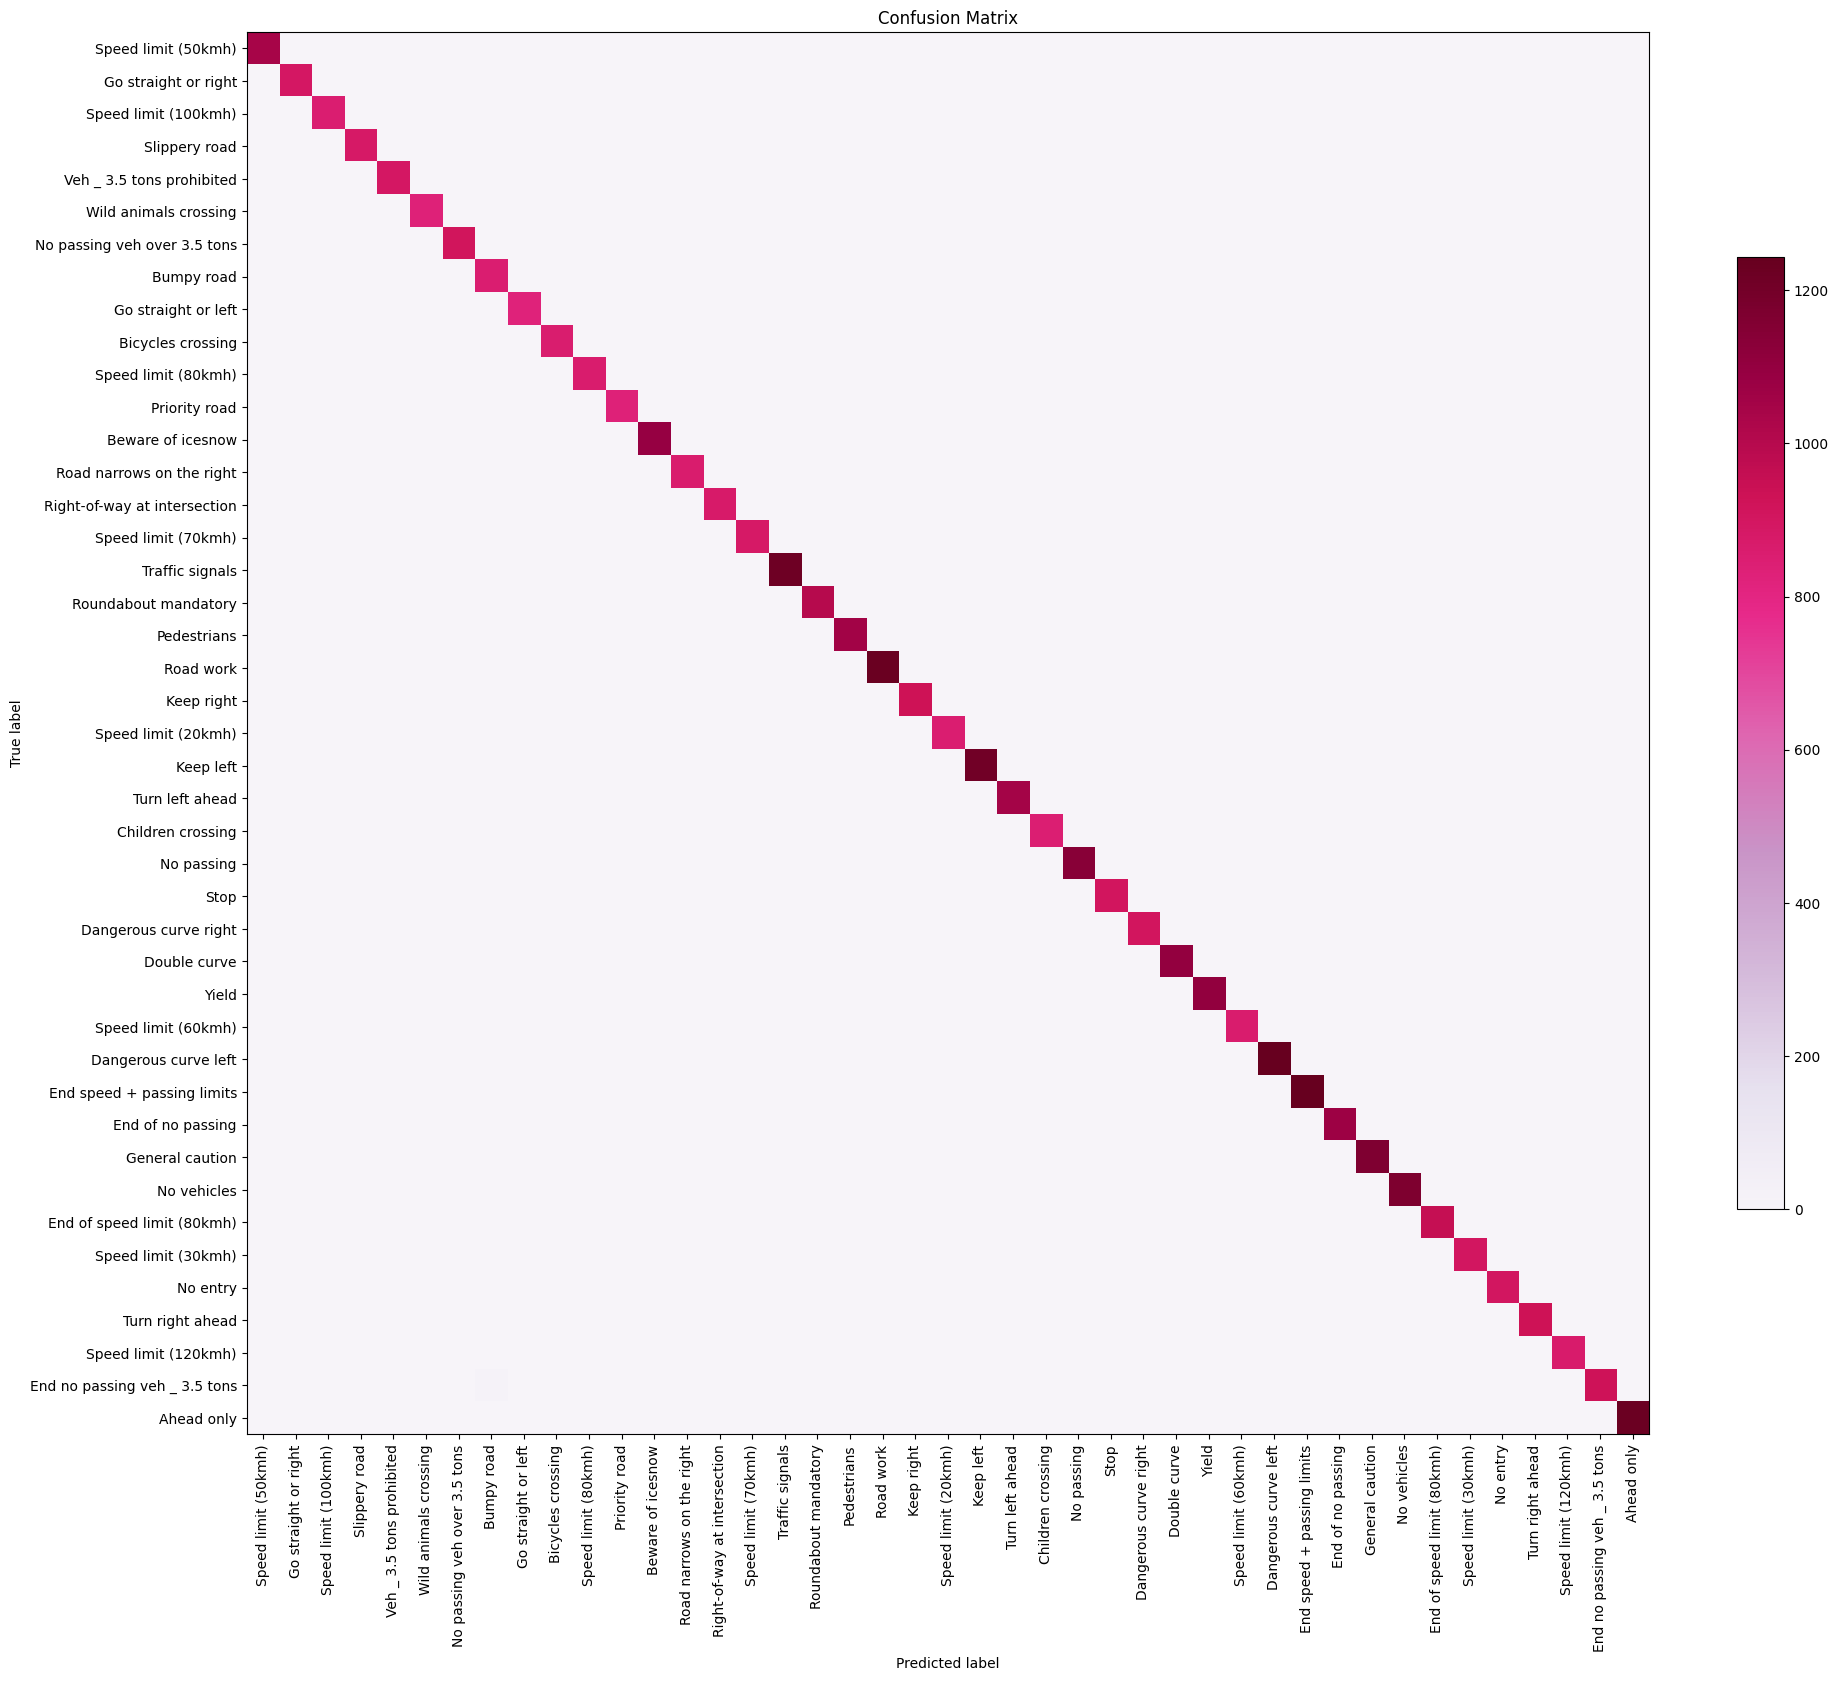

In [32]:
# Assuming 'model' is your PyTorch model and 'val_data' is your validation data loader
y_pred_classes = torch.tensor([])
y_true = torch.tensor([])
class_names = os.listdir('/kaggle/input/adversarial-gtsrb-data/Adversarial-GTSRB-Data')

# Set the model to evaluation mode
model.eval()

with torch.no_grad():  # Deactivate gradients for the following code
    for x, y in val_dataloader:
        # Move the training data to the GPU
        x = x.to(device)
        y = y.to(device)
        
        # Forward pass
        out = model(x)
        
        # Predicted class is the one with highest probability
        _, predicted = torch.max(out, dim=1)
        
        # Join the predicted classes
        y_pred_classes = torch.cat([y_pred_classes, predicted.cpu()])
        
        # Join the correct classes
        y_true = torch.cat([y_true, y.cpu()])

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true.numpy(), y_pred_classes.numpy())

plt.figure(figsize=(20, 20))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)
plt.title('Confusion Matrix')
plt.colorbar(shrink=0.5)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

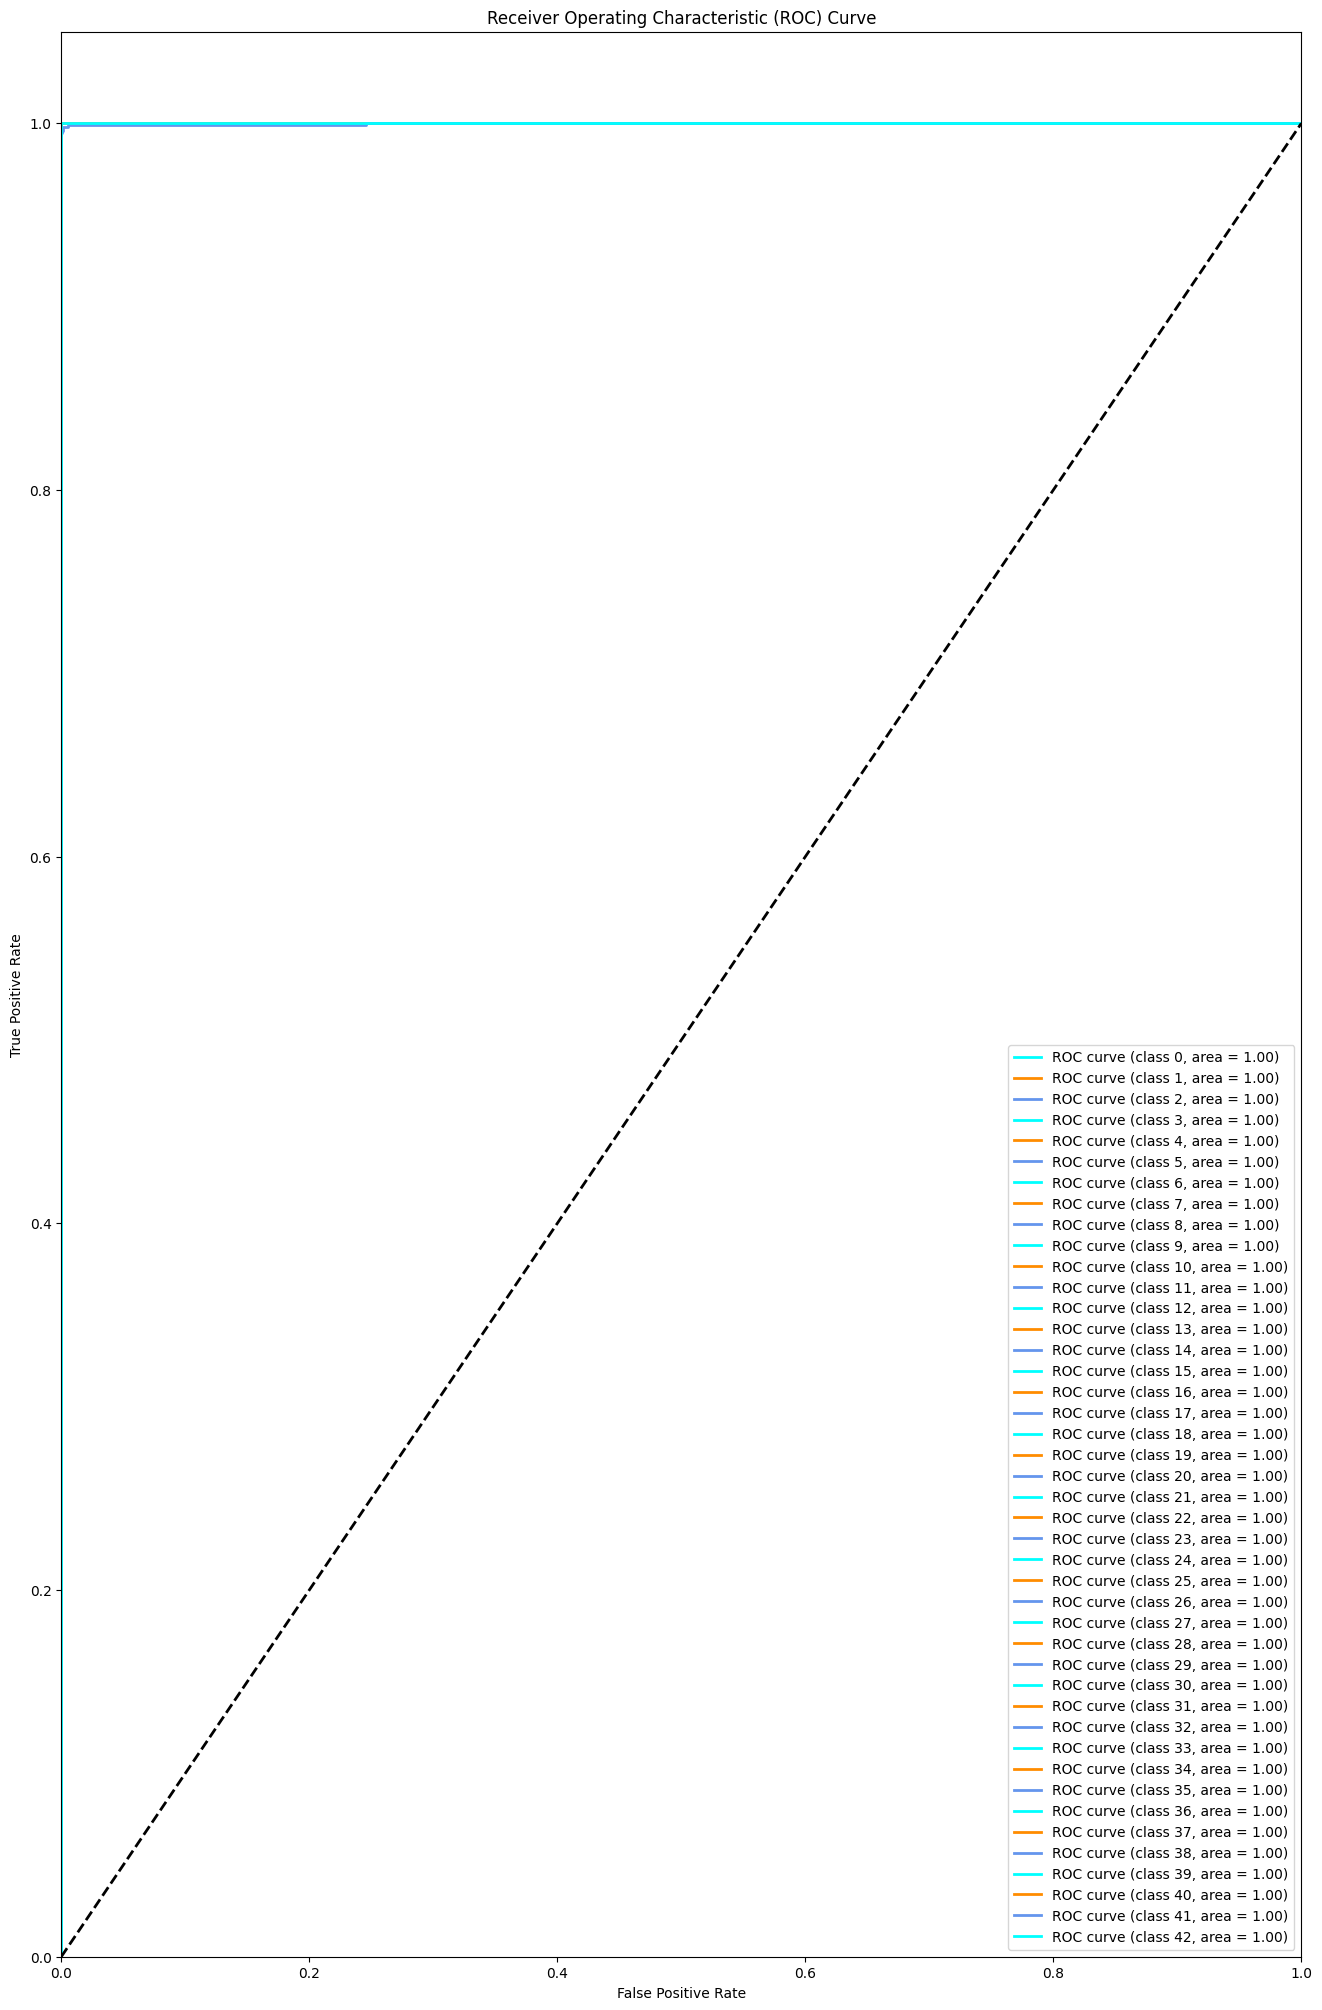

In [36]:
import torch
import torch.nn.functional as F

# Assuming 'model' is your PyTorch model and 'val_data' is your validation DataLoader
y_score = torch.tensor([])
y_true = torch.tensor([])
n_classes = 43

# Set the model to evaluation mode
model.eval()

with torch.no_grad():  # Deactivate gradients for the following code
    for x, y in val_dataloader:
        # Move the data to the GPU
        x = x.to(device)
        y = y.to(device)
        
        # Forward pass
        out = model(x)
        
        # Apply softmax to the output to get probabilities
        probs = F.softmax(out, dim=1)
        
        # Concatenate the probabilities and true labels
        y_score = torch.cat([y_score, probs.cpu()])
        y_true = torch.cat([y_true, y.cpu()])

from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true.numpy(), classes=np.arange(n_classes))

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i].numpy())
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(16, 25))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()